# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2017-08-03 09:48:00,468] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [16]:
env.reset()
rewards = []
for _ in range(200):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [17]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [18]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [19]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [27]:
train_episodes = 5000          # max number of episodes to learn from
max_steps = 500                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.001            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 128               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 40                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [28]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [29]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [30]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 4.0 Training loss: 1.0852 Explore P: 0.9996
Episode: 2 Total reward: 31.0 Training loss: 1.0649 Explore P: 0.9965
Episode: 3 Total reward: 19.0 Training loss: 1.1551 Explore P: 0.9947
Episode: 4 Total reward: 27.0 Training loss: 1.1666 Explore P: 0.9920
Episode: 5 Total reward: 9.0 Training loss: 1.1316 Explore P: 0.9911
Episode: 6 Total reward: 28.0 Training loss: 1.2675 Explore P: 0.9884
Episode: 7 Total reward: 20.0 Training loss: 1.2981 Explore P: 0.9864
Episode: 8 Total reward: 9.0 Training loss: 1.2268 Explore P: 0.9856
Episode: 9 Total reward: 27.0 Training loss: 1.5585 Explore P: 0.9829
Episode: 10 Total reward: 11.0 Training loss: 1.4009 Explore P: 0.9819
Episode: 11 Total reward: 21.0 Training loss: 1.7090 Explore P: 0.9798
Episode: 12 Total reward: 10.0 Training loss: 1.4842 Explore P: 0.9788
Episode: 13 Total reward: 22.0 Training loss: 2.0137 Explore P: 0.9767
Episode: 14 Total reward: 27.0 Training loss: 3.0296 Explore P: 0.9741
Episode: 15 Total 

Episode: 120 Total reward: 14.0 Training loss: 48.9803 Explore P: 0.7934
Episode: 121 Total reward: 14.0 Training loss: 1.0011 Explore P: 0.7923
Episode: 122 Total reward: 23.0 Training loss: 0.8326 Explore P: 0.7905
Episode: 123 Total reward: 24.0 Training loss: 8.6791 Explore P: 0.7886
Episode: 124 Total reward: 33.0 Training loss: 34.5941 Explore P: 0.7860
Episode: 125 Total reward: 13.0 Training loss: 9.0397 Explore P: 0.7850
Episode: 126 Total reward: 9.0 Training loss: 40.5638 Explore P: 0.7843
Episode: 127 Total reward: 40.0 Training loss: 27.1909 Explore P: 0.7812
Episode: 128 Total reward: 24.0 Training loss: 16.0696 Explore P: 0.7794
Episode: 129 Total reward: 26.0 Training loss: 22.6033 Explore P: 0.7774
Episode: 130 Total reward: 40.0 Training loss: 29.1070 Explore P: 0.7743
Episode: 131 Total reward: 9.0 Training loss: 23.0722 Explore P: 0.7736
Episode: 132 Total reward: 27.0 Training loss: 23.5683 Explore P: 0.7716
Episode: 133 Total reward: 16.0 Training loss: 26.5908 Ex

Episode: 234 Total reward: 110.0 Training loss: 49.3236 Explore P: 0.4483
Episode: 235 Total reward: 51.0 Training loss: 43.8947 Explore P: 0.4460
Episode: 236 Total reward: 162.0 Training loss: 42.6200 Explore P: 0.4390
Episode: 237 Total reward: 89.0 Training loss: 107.5615 Explore P: 0.4352
Episode: 238 Total reward: 63.0 Training loss: 43.6599 Explore P: 0.4325
Episode: 239 Total reward: 192.0 Training loss: 32.5453 Explore P: 0.4245
Episode: 240 Total reward: 76.0 Training loss: 5.9837 Explore P: 0.4214
Episode: 241 Total reward: 176.0 Training loss: 4.7739 Explore P: 0.4142
Episode: 242 Total reward: 73.0 Training loss: 35.8955 Explore P: 0.4113
Episode: 243 Total reward: 18.0 Training loss: 100.2728 Explore P: 0.4105
Episode: 244 Total reward: 103.0 Training loss: 18.0404 Explore P: 0.4064
Episode: 245 Total reward: 138.0 Training loss: 4.3510 Explore P: 0.4010
Episode: 246 Total reward: 72.0 Training loss: 4.1831 Explore P: 0.3982
Episode: 247 Total reward: 71.0 Training loss: 

Episode: 346 Total reward: 199.0 Training loss: 0.2631 Explore P: 0.0724
Episode: 347 Total reward: 199.0 Training loss: 0.1507 Explore P: 0.0711
Episode: 348 Total reward: 199.0 Training loss: 0.1427 Explore P: 0.0699
Episode: 349 Total reward: 199.0 Training loss: 0.2537 Explore P: 0.0687
Episode: 350 Total reward: 199.0 Training loss: 0.1732 Explore P: 0.0676
Episode: 351 Total reward: 199.0 Training loss: 0.2982 Explore P: 0.0664
Episode: 352 Total reward: 199.0 Training loss: 0.8178 Explore P: 0.0653
Episode: 353 Total reward: 199.0 Training loss: 17.7836 Explore P: 0.0642
Episode: 354 Total reward: 199.0 Training loss: 0.2024 Explore P: 0.0632
Episode: 355 Total reward: 199.0 Training loss: 0.3231 Explore P: 0.0621
Episode: 356 Total reward: 199.0 Training loss: 0.2561 Explore P: 0.0611
Episode: 357 Total reward: 199.0 Training loss: 0.2405 Explore P: 0.0601
Episode: 358 Total reward: 199.0 Training loss: 0.1652 Explore P: 0.0591
Episode: 359 Total reward: 199.0 Training loss: 0.

Episode: 458 Total reward: 199.0 Training loss: 0.5486 Explore P: 0.0189
Episode: 459 Total reward: 199.0 Training loss: 0.2573 Explore P: 0.0187
Episode: 460 Total reward: 199.0 Training loss: 0.5232 Explore P: 0.0186
Episode: 461 Total reward: 199.0 Training loss: 0.4873 Explore P: 0.0184
Episode: 462 Total reward: 199.0 Training loss: 257.9586 Explore P: 0.0182
Episode: 463 Total reward: 199.0 Training loss: 416.4316 Explore P: 0.0181
Episode: 464 Total reward: 199.0 Training loss: 0.4006 Explore P: 0.0179
Episode: 465 Total reward: 199.0 Training loss: 0.4749 Explore P: 0.0178
Episode: 466 Total reward: 199.0 Training loss: 0.3275 Explore P: 0.0176
Episode: 467 Total reward: 199.0 Training loss: 0.3630 Explore P: 0.0175
Episode: 468 Total reward: 199.0 Training loss: 0.4356 Explore P: 0.0173
Episode: 469 Total reward: 199.0 Training loss: 54.4316 Explore P: 0.0172
Episode: 470 Total reward: 199.0 Training loss: 194.7174 Explore P: 0.0170
Episode: 471 Total reward: 199.0 Training lo

Episode: 570 Total reward: 199.0 Training loss: 0.4841 Explore P: 0.0112
Episode: 571 Total reward: 199.0 Training loss: 0.3283 Explore P: 0.0112
Episode: 572 Total reward: 199.0 Training loss: 0.2097 Explore P: 0.0112
Episode: 573 Total reward: 199.0 Training loss: 0.2079 Explore P: 0.0112
Episode: 574 Total reward: 199.0 Training loss: 203.3685 Explore P: 0.0111
Episode: 575 Total reward: 199.0 Training loss: 0.3027 Explore P: 0.0111
Episode: 576 Total reward: 199.0 Training loss: 121.9013 Explore P: 0.0111
Episode: 577 Total reward: 199.0 Training loss: 87.9908 Explore P: 0.0111
Episode: 578 Total reward: 199.0 Training loss: 111.8389 Explore P: 0.0110
Episode: 579 Total reward: 199.0 Training loss: 0.2906 Explore P: 0.0110
Episode: 580 Total reward: 199.0 Training loss: 0.5371 Explore P: 0.0110
Episode: 581 Total reward: 199.0 Training loss: 0.1218 Explore P: 0.0110
Episode: 582 Total reward: 199.0 Training loss: 307.2520 Explore P: 0.0110
Episode: 583 Total reward: 199.0 Training 

Episode: 682 Total reward: 88.0 Training loss: 1.0115 Explore P: 0.0101
Episode: 683 Total reward: 8.0 Training loss: 0.8292 Explore P: 0.0101
Episode: 684 Total reward: 10.0 Training loss: 0.6097 Explore P: 0.0101
Episode: 685 Total reward: 199.0 Training loss: 0.0472 Explore P: 0.0101
Episode: 686 Total reward: 199.0 Training loss: 0.2552 Explore P: 0.0101
Episode: 687 Total reward: 199.0 Training loss: 61.6172 Explore P: 0.0101
Episode: 688 Total reward: 199.0 Training loss: 122.5524 Explore P: 0.0101
Episode: 689 Total reward: 199.0 Training loss: 94.6897 Explore P: 0.0101
Episode: 690 Total reward: 199.0 Training loss: 0.1907 Explore P: 0.0101
Episode: 691 Total reward: 199.0 Training loss: 0.3211 Explore P: 0.0101
Episode: 692 Total reward: 199.0 Training loss: 0.7399 Explore P: 0.0101
Episode: 693 Total reward: 199.0 Training loss: 0.3131 Explore P: 0.0101
Episode: 694 Total reward: 199.0 Training loss: 0.7278 Explore P: 0.0101
Episode: 695 Total reward: 199.0 Training loss: 0.4

Episode: 795 Total reward: 199.0 Training loss: 1.9069 Explore P: 0.0100
Episode: 796 Total reward: 199.0 Training loss: 3.3981 Explore P: 0.0100
Episode: 797 Total reward: 199.0 Training loss: 6.5163 Explore P: 0.0100
Episode: 798 Total reward: 199.0 Training loss: 4.3664 Explore P: 0.0100
Episode: 799 Total reward: 199.0 Training loss: 7.9722 Explore P: 0.0100
Episode: 800 Total reward: 164.0 Training loss: 9.3095 Explore P: 0.0100
Episode: 801 Total reward: 147.0 Training loss: 16.2557 Explore P: 0.0100
Episode: 802 Total reward: 125.0 Training loss: 12.2995 Explore P: 0.0100
Episode: 803 Total reward: 110.0 Training loss: 14.4074 Explore P: 0.0100
Episode: 804 Total reward: 18.0 Training loss: 14.1360 Explore P: 0.0100
Episode: 805 Total reward: 13.0 Training loss: 20.4286 Explore P: 0.0100
Episode: 806 Total reward: 15.0 Training loss: 23.3119 Explore P: 0.0100
Episode: 807 Total reward: 13.0 Training loss: 29.5341 Explore P: 0.0100
Episode: 808 Total reward: 10.0 Training loss: 1

Episode: 907 Total reward: 199.0 Training loss: 0.4968 Explore P: 0.0100
Episode: 908 Total reward: 199.0 Training loss: 0.4219 Explore P: 0.0100
Episode: 909 Total reward: 199.0 Training loss: 0.2531 Explore P: 0.0100
Episode: 910 Total reward: 199.0 Training loss: 0.1999 Explore P: 0.0100
Episode: 911 Total reward: 199.0 Training loss: 0.1706 Explore P: 0.0100
Episode: 912 Total reward: 199.0 Training loss: 137.5963 Explore P: 0.0100
Episode: 913 Total reward: 199.0 Training loss: 0.2395 Explore P: 0.0100
Episode: 914 Total reward: 199.0 Training loss: 0.6858 Explore P: 0.0100
Episode: 915 Total reward: 199.0 Training loss: 0.4904 Explore P: 0.0100
Episode: 916 Total reward: 199.0 Training loss: 0.6855 Explore P: 0.0100
Episode: 917 Total reward: 199.0 Training loss: 0.2651 Explore P: 0.0100
Episode: 918 Total reward: 199.0 Training loss: 0.3299 Explore P: 0.0100
Episode: 919 Total reward: 199.0 Training loss: 146.3801 Explore P: 0.0100
Episode: 920 Total reward: 199.0 Training loss:

Episode: 1019 Total reward: 187.0 Training loss: 0.4488 Explore P: 0.0100
Episode: 1020 Total reward: 188.0 Training loss: 0.3318 Explore P: 0.0100
Episode: 1021 Total reward: 190.0 Training loss: 2.0601 Explore P: 0.0100
Episode: 1022 Total reward: 197.0 Training loss: 0.2891 Explore P: 0.0100
Episode: 1023 Total reward: 193.0 Training loss: 0.5715 Explore P: 0.0100
Episode: 1024 Total reward: 161.0 Training loss: 103.2523 Explore P: 0.0100
Episode: 1025 Total reward: 199.0 Training loss: 0.5215 Explore P: 0.0100
Episode: 1026 Total reward: 193.0 Training loss: 0.3119 Explore P: 0.0100
Episode: 1027 Total reward: 199.0 Training loss: 17.9409 Explore P: 0.0100
Episode: 1028 Total reward: 167.0 Training loss: 0.4406 Explore P: 0.0100
Episode: 1029 Total reward: 181.0 Training loss: 0.4072 Explore P: 0.0100
Episode: 1030 Total reward: 163.0 Training loss: 0.7875 Explore P: 0.0100
Episode: 1031 Total reward: 135.0 Training loss: 0.5528 Explore P: 0.0100
Episode: 1032 Total reward: 138.0 T

Episode: 1131 Total reward: 21.0 Training loss: 3.4262 Explore P: 0.0100
Episode: 1132 Total reward: 13.0 Training loss: 36.4867 Explore P: 0.0100
Episode: 1133 Total reward: 18.0 Training loss: 79.3050 Explore P: 0.0100
Episode: 1134 Total reward: 17.0 Training loss: 3.9898 Explore P: 0.0100
Episode: 1135 Total reward: 13.0 Training loss: 4.5907 Explore P: 0.0100
Episode: 1136 Total reward: 14.0 Training loss: 3.7478 Explore P: 0.0100
Episode: 1137 Total reward: 14.0 Training loss: 5.6863 Explore P: 0.0100
Episode: 1138 Total reward: 15.0 Training loss: 3.6626 Explore P: 0.0100
Episode: 1139 Total reward: 12.0 Training loss: 3.7707 Explore P: 0.0100
Episode: 1140 Total reward: 16.0 Training loss: 619.9733 Explore P: 0.0100
Episode: 1141 Total reward: 11.0 Training loss: 6.3226 Explore P: 0.0100
Episode: 1142 Total reward: 14.0 Training loss: 4.4971 Explore P: 0.0100
Episode: 1143 Total reward: 17.0 Training loss: 4.8563 Explore P: 0.0100
Episode: 1144 Total reward: 12.0 Training loss:

Episode: 1242 Total reward: 197.0 Training loss: 0.1969 Explore P: 0.0100
Episode: 1243 Total reward: 199.0 Training loss: 0.0745 Explore P: 0.0100
Episode: 1244 Total reward: 187.0 Training loss: 0.2758 Explore P: 0.0100
Episode: 1245 Total reward: 197.0 Training loss: 89.7252 Explore P: 0.0100
Episode: 1246 Total reward: 171.0 Training loss: 0.1829 Explore P: 0.0100
Episode: 1247 Total reward: 199.0 Training loss: 0.3322 Explore P: 0.0100
Episode: 1248 Total reward: 185.0 Training loss: 0.1475 Explore P: 0.0100
Episode: 1249 Total reward: 181.0 Training loss: 7.9645 Explore P: 0.0100
Episode: 1250 Total reward: 199.0 Training loss: 92.2579 Explore P: 0.0100
Episode: 1251 Total reward: 187.0 Training loss: 0.1710 Explore P: 0.0100
Episode: 1252 Total reward: 185.0 Training loss: 0.1461 Explore P: 0.0100
Episode: 1253 Total reward: 179.0 Training loss: 3.6816 Explore P: 0.0100
Episode: 1254 Total reward: 194.0 Training loss: 0.1237 Explore P: 0.0100
Episode: 1255 Total reward: 165.0 Tr

Episode: 1353 Total reward: 114.0 Training loss: 0.3027 Explore P: 0.0100
Episode: 1354 Total reward: 197.0 Training loss: 0.2073 Explore P: 0.0100
Episode: 1355 Total reward: 187.0 Training loss: 0.4578 Explore P: 0.0100
Episode: 1356 Total reward: 173.0 Training loss: 0.2338 Explore P: 0.0100
Episode: 1357 Total reward: 165.0 Training loss: 0.1605 Explore P: 0.0100
Episode: 1358 Total reward: 160.0 Training loss: 0.2683 Explore P: 0.0100
Episode: 1359 Total reward: 165.0 Training loss: 0.1702 Explore P: 0.0100
Episode: 1360 Total reward: 161.0 Training loss: 0.2698 Explore P: 0.0100
Episode: 1361 Total reward: 154.0 Training loss: 0.3236 Explore P: 0.0100
Episode: 1362 Total reward: 159.0 Training loss: 0.1583 Explore P: 0.0100
Episode: 1363 Total reward: 154.0 Training loss: 0.2075 Explore P: 0.0100
Episode: 1364 Total reward: 199.0 Training loss: 1.1586 Explore P: 0.0100
Episode: 1365 Total reward: 199.0 Training loss: 0.2739 Explore P: 0.0100
Episode: 1366 Total reward: 199.0 Trai

Episode: 1464 Total reward: 199.0 Training loss: 0.3901 Explore P: 0.0100
Episode: 1465 Total reward: 199.0 Training loss: 0.4497 Explore P: 0.0100
Episode: 1466 Total reward: 199.0 Training loss: 9.3464 Explore P: 0.0100
Episode: 1467 Total reward: 199.0 Training loss: 0.1672 Explore P: 0.0100
Episode: 1468 Total reward: 199.0 Training loss: 2.6328 Explore P: 0.0100
Episode: 1469 Total reward: 199.0 Training loss: 0.1797 Explore P: 0.0100
Episode: 1470 Total reward: 199.0 Training loss: 0.2803 Explore P: 0.0100
Episode: 1471 Total reward: 199.0 Training loss: 111.6928 Explore P: 0.0100
Episode: 1472 Total reward: 199.0 Training loss: 40.5527 Explore P: 0.0100
Episode: 1473 Total reward: 199.0 Training loss: 0.3393 Explore P: 0.0100
Episode: 1474 Total reward: 199.0 Training loss: 0.1107 Explore P: 0.0100
Episode: 1475 Total reward: 199.0 Training loss: 0.2108 Explore P: 0.0100
Episode: 1476 Total reward: 194.0 Training loss: 0.1878 Explore P: 0.0100
Episode: 1477 Total reward: 199.0 T

Episode: 1575 Total reward: 195.0 Training loss: 0.1549 Explore P: 0.0100
Episode: 1576 Total reward: 174.0 Training loss: 0.1894 Explore P: 0.0100
Episode: 1577 Total reward: 199.0 Training loss: 0.1454 Explore P: 0.0100
Episode: 1578 Total reward: 180.0 Training loss: 0.1724 Explore P: 0.0100
Episode: 1579 Total reward: 168.0 Training loss: 0.1498 Explore P: 0.0100
Episode: 1580 Total reward: 199.0 Training loss: 0.1638 Explore P: 0.0100
Episode: 1581 Total reward: 199.0 Training loss: 0.2534 Explore P: 0.0100
Episode: 1582 Total reward: 199.0 Training loss: 0.2179 Explore P: 0.0100
Episode: 1583 Total reward: 185.0 Training loss: 0.1892 Explore P: 0.0100
Episode: 1584 Total reward: 199.0 Training loss: 0.1384 Explore P: 0.0100
Episode: 1585 Total reward: 199.0 Training loss: 0.1872 Explore P: 0.0100
Episode: 1586 Total reward: 186.0 Training loss: 0.1641 Explore P: 0.0100
Episode: 1587 Total reward: 199.0 Training loss: 0.1452 Explore P: 0.0100
Episode: 1588 Total reward: 199.0 Trai

Episode: 1686 Total reward: 199.0 Training loss: 0.1101 Explore P: 0.0100
Episode: 1687 Total reward: 199.0 Training loss: 0.1759 Explore P: 0.0100
Episode: 1688 Total reward: 199.0 Training loss: 0.0724 Explore P: 0.0100
Episode: 1689 Total reward: 199.0 Training loss: 0.1681 Explore P: 0.0100
Episode: 1690 Total reward: 199.0 Training loss: 42.1395 Explore P: 0.0100
Episode: 1691 Total reward: 199.0 Training loss: 0.1973 Explore P: 0.0100
Episode: 1692 Total reward: 199.0 Training loss: 0.0755 Explore P: 0.0100
Episode: 1693 Total reward: 199.0 Training loss: 0.1383 Explore P: 0.0100
Episode: 1694 Total reward: 199.0 Training loss: 0.2091 Explore P: 0.0100
Episode: 1695 Total reward: 199.0 Training loss: 0.2690 Explore P: 0.0100
Episode: 1696 Total reward: 199.0 Training loss: 0.1937 Explore P: 0.0100
Episode: 1697 Total reward: 199.0 Training loss: 0.0987 Explore P: 0.0100
Episode: 1698 Total reward: 199.0 Training loss: 0.1335 Explore P: 0.0100
Episode: 1699 Total reward: 199.0 Tra

Episode: 1797 Total reward: 199.0 Training loss: 3.4146 Explore P: 0.0100
Episode: 1798 Total reward: 199.0 Training loss: 1.1765 Explore P: 0.0100
Episode: 1799 Total reward: 199.0 Training loss: 0.9187 Explore P: 0.0100
Episode: 1800 Total reward: 199.0 Training loss: 0.7668 Explore P: 0.0100
Episode: 1801 Total reward: 199.0 Training loss: 1.1141 Explore P: 0.0100
Episode: 1802 Total reward: 199.0 Training loss: 50.7707 Explore P: 0.0100
Episode: 1803 Total reward: 199.0 Training loss: 0.8241 Explore P: 0.0100
Episode: 1804 Total reward: 199.0 Training loss: 3.1069 Explore P: 0.0100
Episode: 1805 Total reward: 199.0 Training loss: 3.4985 Explore P: 0.0100
Episode: 1806 Total reward: 199.0 Training loss: 2.9057 Explore P: 0.0100
Episode: 1807 Total reward: 199.0 Training loss: 1.1317 Explore P: 0.0100
Episode: 1808 Total reward: 199.0 Training loss: 4.3392 Explore P: 0.0100
Episode: 1809 Total reward: 199.0 Training loss: 3.2624 Explore P: 0.0100
Episode: 1810 Total reward: 199.0 Tra

Episode: 1908 Total reward: 199.0 Training loss: 84.8743 Explore P: 0.0100
Episode: 1909 Total reward: 199.0 Training loss: 0.1765 Explore P: 0.0100
Episode: 1910 Total reward: 199.0 Training loss: 0.2410 Explore P: 0.0100
Episode: 1911 Total reward: 199.0 Training loss: 132.7359 Explore P: 0.0100
Episode: 1912 Total reward: 199.0 Training loss: 0.1371 Explore P: 0.0100
Episode: 1913 Total reward: 199.0 Training loss: 0.3069 Explore P: 0.0100
Episode: 1914 Total reward: 199.0 Training loss: 0.3107 Explore P: 0.0100
Episode: 1915 Total reward: 199.0 Training loss: 0.2162 Explore P: 0.0100
Episode: 1916 Total reward: 199.0 Training loss: 0.3116 Explore P: 0.0100
Episode: 1917 Total reward: 199.0 Training loss: 0.2821 Explore P: 0.0100
Episode: 1918 Total reward: 199.0 Training loss: 0.3543 Explore P: 0.0100
Episode: 1919 Total reward: 199.0 Training loss: 0.2257 Explore P: 0.0100
Episode: 1920 Total reward: 199.0 Training loss: 0.2941 Explore P: 0.0100
Episode: 1921 Total reward: 199.0 T

Episode: 2019 Total reward: 199.0 Training loss: 0.1353 Explore P: 0.0100
Episode: 2020 Total reward: 199.0 Training loss: 0.2106 Explore P: 0.0100
Episode: 2021 Total reward: 199.0 Training loss: 0.1999 Explore P: 0.0100
Episode: 2022 Total reward: 199.0 Training loss: 0.3489 Explore P: 0.0100
Episode: 2023 Total reward: 199.0 Training loss: 0.1951 Explore P: 0.0100
Episode: 2024 Total reward: 199.0 Training loss: 144.4956 Explore P: 0.0100
Episode: 2025 Total reward: 199.0 Training loss: 0.2070 Explore P: 0.0100
Episode: 2026 Total reward: 199.0 Training loss: 0.2203 Explore P: 0.0100
Episode: 2027 Total reward: 199.0 Training loss: 0.1748 Explore P: 0.0100
Episode: 2028 Total reward: 199.0 Training loss: 0.1854 Explore P: 0.0100
Episode: 2029 Total reward: 199.0 Training loss: 0.1813 Explore P: 0.0100
Episode: 2030 Total reward: 199.0 Training loss: 0.2098 Explore P: 0.0100
Episode: 2031 Total reward: 199.0 Training loss: 0.2390 Explore P: 0.0100
Episode: 2032 Total reward: 199.0 Tr

Episode: 2133 Total reward: 10.0 Training loss: 4510.5986 Explore P: 0.0100
Episode: 2134 Total reward: 8.0 Training loss: 13.8712 Explore P: 0.0100
Episode: 2135 Total reward: 11.0 Training loss: 4251.6099 Explore P: 0.0100
Episode: 2136 Total reward: 10.0 Training loss: 16.6578 Explore P: 0.0100
Episode: 2137 Total reward: 10.0 Training loss: 956.3332 Explore P: 0.0100
Episode: 2138 Total reward: 11.0 Training loss: 11.2674 Explore P: 0.0100
Episode: 2139 Total reward: 10.0 Training loss: 4297.5498 Explore P: 0.0100
Episode: 2140 Total reward: 11.0 Training loss: 16.8674 Explore P: 0.0100
Episode: 2141 Total reward: 9.0 Training loss: 998.9767 Explore P: 0.0100
Episode: 2142 Total reward: 9.0 Training loss: 15.1174 Explore P: 0.0100
Episode: 2143 Total reward: 11.0 Training loss: 2854.1904 Explore P: 0.0100
Episode: 2144 Total reward: 10.0 Training loss: 20.5377 Explore P: 0.0100
Episode: 2145 Total reward: 9.0 Training loss: 19.5552 Explore P: 0.0100
Episode: 2146 Total reward: 10.0

Episode: 2244 Total reward: 199.0 Training loss: 0.1486 Explore P: 0.0100
Episode: 2245 Total reward: 199.0 Training loss: 0.2462 Explore P: 0.0100
Episode: 2246 Total reward: 199.0 Training loss: 0.3340 Explore P: 0.0100
Episode: 2247 Total reward: 199.0 Training loss: 0.2235 Explore P: 0.0100
Episode: 2248 Total reward: 199.0 Training loss: 18.0041 Explore P: 0.0100
Episode: 2249 Total reward: 199.0 Training loss: 160.0843 Explore P: 0.0100
Episode: 2250 Total reward: 199.0 Training loss: 0.2480 Explore P: 0.0100
Episode: 2251 Total reward: 199.0 Training loss: 48.2404 Explore P: 0.0100
Episode: 2252 Total reward: 199.0 Training loss: 133.6642 Explore P: 0.0100
Episode: 2253 Total reward: 199.0 Training loss: 119.9910 Explore P: 0.0100
Episode: 2254 Total reward: 199.0 Training loss: 0.2143 Explore P: 0.0100
Episode: 2255 Total reward: 199.0 Training loss: 0.1297 Explore P: 0.0100
Episode: 2256 Total reward: 199.0 Training loss: 94.7326 Explore P: 0.0100
Episode: 2257 Total reward: 1

Episode: 2355 Total reward: 199.0 Training loss: 0.2070 Explore P: 0.0100
Episode: 2356 Total reward: 199.0 Training loss: 0.1957 Explore P: 0.0100
Episode: 2357 Total reward: 199.0 Training loss: 0.1122 Explore P: 0.0100
Episode: 2358 Total reward: 199.0 Training loss: 185.3164 Explore P: 0.0100
Episode: 2359 Total reward: 199.0 Training loss: 0.2044 Explore P: 0.0100
Episode: 2360 Total reward: 199.0 Training loss: 0.1151 Explore P: 0.0100
Episode: 2361 Total reward: 199.0 Training loss: 0.1386 Explore P: 0.0100
Episode: 2362 Total reward: 199.0 Training loss: 121.4083 Explore P: 0.0100
Episode: 2363 Total reward: 199.0 Training loss: 0.1508 Explore P: 0.0100
Episode: 2364 Total reward: 199.0 Training loss: 0.1552 Explore P: 0.0100
Episode: 2365 Total reward: 199.0 Training loss: 0.1544 Explore P: 0.0100
Episode: 2366 Total reward: 199.0 Training loss: 0.1275 Explore P: 0.0100
Episode: 2367 Total reward: 199.0 Training loss: 9.5739 Explore P: 0.0100
Episode: 2368 Total reward: 199.0 

Episode: 2466 Total reward: 199.0 Training loss: 0.3793 Explore P: 0.0100
Episode: 2467 Total reward: 199.0 Training loss: 245.7913 Explore P: 0.0100
Episode: 2468 Total reward: 199.0 Training loss: 0.5632 Explore P: 0.0100
Episode: 2469 Total reward: 199.0 Training loss: 0.4927 Explore P: 0.0100
Episode: 2470 Total reward: 199.0 Training loss: 35.9901 Explore P: 0.0100
Episode: 2471 Total reward: 199.0 Training loss: 0.5785 Explore P: 0.0100
Episode: 2472 Total reward: 199.0 Training loss: 0.3345 Explore P: 0.0100
Episode: 2473 Total reward: 199.0 Training loss: 0.2657 Explore P: 0.0100
Episode: 2474 Total reward: 199.0 Training loss: 0.4679 Explore P: 0.0100
Episode: 2475 Total reward: 199.0 Training loss: 40.3238 Explore P: 0.0100
Episode: 2476 Total reward: 199.0 Training loss: 0.5116 Explore P: 0.0100
Episode: 2477 Total reward: 199.0 Training loss: 0.3117 Explore P: 0.0100
Episode: 2478 Total reward: 199.0 Training loss: 95.7475 Explore P: 0.0100
Episode: 2479 Total reward: 199.0

Episode: 2577 Total reward: 199.0 Training loss: 3.2516 Explore P: 0.0100
Episode: 2578 Total reward: 199.0 Training loss: 1.5037 Explore P: 0.0100
Episode: 2579 Total reward: 199.0 Training loss: 3.4474 Explore P: 0.0100
Episode: 2580 Total reward: 199.0 Training loss: 57.1685 Explore P: 0.0100
Episode: 2581 Total reward: 199.0 Training loss: 3.2691 Explore P: 0.0100
Episode: 2582 Total reward: 199.0 Training loss: 3.4475 Explore P: 0.0100
Episode: 2583 Total reward: 199.0 Training loss: 30.1767 Explore P: 0.0100
Episode: 2584 Total reward: 199.0 Training loss: 6.5474 Explore P: 0.0100
Episode: 2585 Total reward: 199.0 Training loss: 0.8567 Explore P: 0.0100
Episode: 2586 Total reward: 199.0 Training loss: 0.9538 Explore P: 0.0100
Episode: 2587 Total reward: 199.0 Training loss: 3.4266 Explore P: 0.0100
Episode: 2588 Total reward: 199.0 Training loss: 2.5028 Explore P: 0.0100
Episode: 2589 Total reward: 199.0 Training loss: 2.3171 Explore P: 0.0100
Episode: 2590 Total reward: 199.0 Tr

Episode: 2688 Total reward: 199.0 Training loss: 0.2254 Explore P: 0.0100
Episode: 2689 Total reward: 199.0 Training loss: 0.2466 Explore P: 0.0100
Episode: 2690 Total reward: 199.0 Training loss: 0.2235 Explore P: 0.0100
Episode: 2691 Total reward: 199.0 Training loss: 0.1814 Explore P: 0.0100
Episode: 2692 Total reward: 199.0 Training loss: 0.2370 Explore P: 0.0100
Episode: 2693 Total reward: 199.0 Training loss: 0.2414 Explore P: 0.0100
Episode: 2694 Total reward: 199.0 Training loss: 0.2425 Explore P: 0.0100
Episode: 2695 Total reward: 199.0 Training loss: 0.1839 Explore P: 0.0100
Episode: 2696 Total reward: 199.0 Training loss: 0.3943 Explore P: 0.0100
Episode: 2697 Total reward: 199.0 Training loss: 0.2395 Explore P: 0.0100
Episode: 2698 Total reward: 199.0 Training loss: 99.6492 Explore P: 0.0100
Episode: 2699 Total reward: 199.0 Training loss: 0.2320 Explore P: 0.0100
Episode: 2700 Total reward: 199.0 Training loss: 73.1481 Explore P: 0.0100
Episode: 2701 Total reward: 199.0 Tr

Episode: 2799 Total reward: 153.0 Training loss: 0.0665 Explore P: 0.0100
Episode: 2800 Total reward: 199.0 Training loss: 0.0900 Explore P: 0.0100
Episode: 2801 Total reward: 199.0 Training loss: 0.0510 Explore P: 0.0100
Episode: 2802 Total reward: 199.0 Training loss: 0.1562 Explore P: 0.0100
Episode: 2803 Total reward: 199.0 Training loss: 0.1282 Explore P: 0.0100
Episode: 2804 Total reward: 199.0 Training loss: 0.1775 Explore P: 0.0100
Episode: 2805 Total reward: 150.0 Training loss: 0.1588 Explore P: 0.0100
Episode: 2806 Total reward: 199.0 Training loss: 0.1034 Explore P: 0.0100
Episode: 2807 Total reward: 111.0 Training loss: 0.2179 Explore P: 0.0100
Episode: 2808 Total reward: 87.0 Training loss: 0.3768 Explore P: 0.0100
Episode: 2809 Total reward: 199.0 Training loss: 0.1006 Explore P: 0.0100
Episode: 2810 Total reward: 140.0 Training loss: 0.1692 Explore P: 0.0100
Episode: 2811 Total reward: 199.0 Training loss: 6.4691 Explore P: 0.0100
Episode: 2812 Total reward: 199.0 Train

Episode: 2910 Total reward: 69.0 Training loss: 0.6171 Explore P: 0.0100
Episode: 2911 Total reward: 62.0 Training loss: 206.2175 Explore P: 0.0100
Episode: 2912 Total reward: 61.0 Training loss: 1.1777 Explore P: 0.0100
Episode: 2913 Total reward: 47.0 Training loss: 322.1191 Explore P: 0.0100
Episode: 2914 Total reward: 73.0 Training loss: 0.9108 Explore P: 0.0100
Episode: 2915 Total reward: 77.0 Training loss: 1.0457 Explore P: 0.0100
Episode: 2916 Total reward: 86.0 Training loss: 0.6294 Explore P: 0.0100
Episode: 2917 Total reward: 95.0 Training loss: 0.6369 Explore P: 0.0100
Episode: 2918 Total reward: 116.0 Training loss: 300.7817 Explore P: 0.0100
Episode: 2919 Total reward: 160.0 Training loss: 159.4149 Explore P: 0.0100
Episode: 2920 Total reward: 145.0 Training loss: 0.7195 Explore P: 0.0100
Episode: 2921 Total reward: 187.0 Training loss: 0.4361 Explore P: 0.0100
Episode: 2922 Total reward: 199.0 Training loss: 141.5041 Explore P: 0.0100
Episode: 2923 Total reward: 199.0 Tr

Episode: 3021 Total reward: 13.0 Training loss: 78.6184 Explore P: 0.0100
Episode: 3022 Total reward: 9.0 Training loss: 76.0532 Explore P: 0.0100
Episode: 3023 Total reward: 11.0 Training loss: 44.6822 Explore P: 0.0100
Episode: 3024 Total reward: 9.0 Training loss: 30.4428 Explore P: 0.0100
Episode: 3025 Total reward: 9.0 Training loss: 38.5292 Explore P: 0.0100
Episode: 3026 Total reward: 13.0 Training loss: 8076.2983 Explore P: 0.0100
Episode: 3027 Total reward: 11.0 Training loss: 2604.2625 Explore P: 0.0100
Episode: 3028 Total reward: 12.0 Training loss: 41.5541 Explore P: 0.0100
Episode: 3029 Total reward: 11.0 Training loss: 6568.6157 Explore P: 0.0100
Episode: 3030 Total reward: 11.0 Training loss: 72.8568 Explore P: 0.0100
Episode: 3031 Total reward: 9.0 Training loss: 37.0112 Explore P: 0.0100
Episode: 3032 Total reward: 10.0 Training loss: 49.8336 Explore P: 0.0100
Episode: 3033 Total reward: 14.0 Training loss: 30.7919 Explore P: 0.0100
Episode: 3034 Total reward: 55.0 Tra

Episode: 3132 Total reward: 199.0 Training loss: 0.2593 Explore P: 0.0100
Episode: 3133 Total reward: 199.0 Training loss: 75.1933 Explore P: 0.0100
Episode: 3134 Total reward: 199.0 Training loss: 94.8739 Explore P: 0.0100
Episode: 3135 Total reward: 199.0 Training loss: 0.5305 Explore P: 0.0100
Episode: 3136 Total reward: 199.0 Training loss: 0.2326 Explore P: 0.0100
Episode: 3137 Total reward: 199.0 Training loss: 0.2548 Explore P: 0.0100
Episode: 3138 Total reward: 199.0 Training loss: 0.1900 Explore P: 0.0100
Episode: 3139 Total reward: 199.0 Training loss: 0.2718 Explore P: 0.0100
Episode: 3140 Total reward: 199.0 Training loss: 159.3268 Explore P: 0.0100
Episode: 3141 Total reward: 199.0 Training loss: 0.2112 Explore P: 0.0100
Episode: 3142 Total reward: 199.0 Training loss: 58.4503 Explore P: 0.0100
Episode: 3143 Total reward: 199.0 Training loss: 0.1729 Explore P: 0.0100
Episode: 3144 Total reward: 199.0 Training loss: 0.4959 Explore P: 0.0100
Episode: 3145 Total reward: 199.0

Episode: 3243 Total reward: 199.0 Training loss: 1.2244 Explore P: 0.0100
Episode: 3244 Total reward: 199.0 Training loss: 0.5652 Explore P: 0.0100
Episode: 3245 Total reward: 199.0 Training loss: 0.8210 Explore P: 0.0100
Episode: 3246 Total reward: 199.0 Training loss: 0.4476 Explore P: 0.0100
Episode: 3247 Total reward: 199.0 Training loss: 0.3590 Explore P: 0.0100
Episode: 3248 Total reward: 199.0 Training loss: 81.1703 Explore P: 0.0100
Episode: 3249 Total reward: 199.0 Training loss: 31.0146 Explore P: 0.0100
Episode: 3250 Total reward: 199.0 Training loss: 0.7234 Explore P: 0.0100
Episode: 3251 Total reward: 199.0 Training loss: 111.5049 Explore P: 0.0100
Episode: 3252 Total reward: 199.0 Training loss: 0.4522 Explore P: 0.0100
Episode: 3253 Total reward: 199.0 Training loss: 0.4384 Explore P: 0.0100
Episode: 3254 Total reward: 199.0 Training loss: 0.2753 Explore P: 0.0100
Episode: 3255 Total reward: 199.0 Training loss: 0.3096 Explore P: 0.0100
Episode: 3256 Total reward: 199.0 

Episode: 3354 Total reward: 199.0 Training loss: 0.3348 Explore P: 0.0100
Episode: 3355 Total reward: 199.0 Training loss: 0.2800 Explore P: 0.0100
Episode: 3356 Total reward: 199.0 Training loss: 0.3689 Explore P: 0.0100
Episode: 3357 Total reward: 199.0 Training loss: 0.7276 Explore P: 0.0100
Episode: 3358 Total reward: 199.0 Training loss: 0.3313 Explore P: 0.0100
Episode: 3359 Total reward: 199.0 Training loss: 0.6649 Explore P: 0.0100
Episode: 3360 Total reward: 199.0 Training loss: 0.4369 Explore P: 0.0100
Episode: 3361 Total reward: 199.0 Training loss: 0.2026 Explore P: 0.0100
Episode: 3362 Total reward: 199.0 Training loss: 0.2596 Explore P: 0.0100
Episode: 3363 Total reward: 199.0 Training loss: 0.1949 Explore P: 0.0100
Episode: 3364 Total reward: 199.0 Training loss: 0.3234 Explore P: 0.0100
Episode: 3365 Total reward: 199.0 Training loss: 0.3026 Explore P: 0.0100
Episode: 3366 Total reward: 199.0 Training loss: 0.2076 Explore P: 0.0100
Episode: 3367 Total reward: 199.0 Trai

Episode: 3465 Total reward: 199.0 Training loss: 86.9507 Explore P: 0.0100
Episode: 3466 Total reward: 199.0 Training loss: 0.2168 Explore P: 0.0100
Episode: 3467 Total reward: 199.0 Training loss: 0.3123 Explore P: 0.0100
Episode: 3468 Total reward: 199.0 Training loss: 0.5900 Explore P: 0.0100
Episode: 3469 Total reward: 199.0 Training loss: 0.2266 Explore P: 0.0100
Episode: 3470 Total reward: 199.0 Training loss: 0.3042 Explore P: 0.0100
Episode: 3471 Total reward: 199.0 Training loss: 0.3535 Explore P: 0.0100
Episode: 3472 Total reward: 199.0 Training loss: 25.4461 Explore P: 0.0100
Episode: 3473 Total reward: 199.0 Training loss: 117.9852 Explore P: 0.0100
Episode: 3474 Total reward: 199.0 Training loss: 0.3824 Explore P: 0.0100
Episode: 3475 Total reward: 199.0 Training loss: 0.2330 Explore P: 0.0100
Episode: 3476 Total reward: 199.0 Training loss: 0.1960 Explore P: 0.0100
Episode: 3477 Total reward: 199.0 Training loss: 0.5420 Explore P: 0.0100
Episode: 3478 Total reward: 199.0 

Episode: 3576 Total reward: 199.0 Training loss: 0.2299 Explore P: 0.0100
Episode: 3577 Total reward: 199.0 Training loss: 0.2338 Explore P: 0.0100
Episode: 3578 Total reward: 199.0 Training loss: 0.2018 Explore P: 0.0100
Episode: 3579 Total reward: 199.0 Training loss: 0.2005 Explore P: 0.0100
Episode: 3580 Total reward: 199.0 Training loss: 0.2982 Explore P: 0.0100
Episode: 3581 Total reward: 199.0 Training loss: 0.3045 Explore P: 0.0100
Episode: 3582 Total reward: 199.0 Training loss: 85.7185 Explore P: 0.0100
Episode: 3583 Total reward: 199.0 Training loss: 137.1419 Explore P: 0.0100
Episode: 3584 Total reward: 199.0 Training loss: 0.2487 Explore P: 0.0100
Episode: 3585 Total reward: 199.0 Training loss: 0.1613 Explore P: 0.0100
Episode: 3586 Total reward: 199.0 Training loss: 24.5524 Explore P: 0.0100
Episode: 3587 Total reward: 199.0 Training loss: 0.4908 Explore P: 0.0100
Episode: 3588 Total reward: 199.0 Training loss: 0.2588 Explore P: 0.0100
Episode: 3589 Total reward: 199.0 

Episode: 3687 Total reward: 199.0 Training loss: 0.2615 Explore P: 0.0100
Episode: 3688 Total reward: 199.0 Training loss: 223.0468 Explore P: 0.0100
Episode: 3689 Total reward: 199.0 Training loss: 0.1461 Explore P: 0.0100
Episode: 3690 Total reward: 199.0 Training loss: 0.2147 Explore P: 0.0100
Episode: 3691 Total reward: 199.0 Training loss: 0.4824 Explore P: 0.0100
Episode: 3692 Total reward: 199.0 Training loss: 0.2122 Explore P: 0.0100
Episode: 3693 Total reward: 199.0 Training loss: 0.1568 Explore P: 0.0100
Episode: 3694 Total reward: 199.0 Training loss: 0.1508 Explore P: 0.0100
Episode: 3695 Total reward: 199.0 Training loss: 0.1222 Explore P: 0.0100
Episode: 3696 Total reward: 199.0 Training loss: 0.1319 Explore P: 0.0100
Episode: 3697 Total reward: 199.0 Training loss: 0.1214 Explore P: 0.0100
Episode: 3698 Total reward: 199.0 Training loss: 18.2262 Explore P: 0.0100
Episode: 3699 Total reward: 199.0 Training loss: 0.1441 Explore P: 0.0100
Episode: 3700 Total reward: 199.0 T

Episode: 3798 Total reward: 199.0 Training loss: 0.1112 Explore P: 0.0100
Episode: 3799 Total reward: 199.0 Training loss: 8.1007 Explore P: 0.0100
Episode: 3800 Total reward: 199.0 Training loss: 0.0662 Explore P: 0.0100
Episode: 3801 Total reward: 199.0 Training loss: 0.1024 Explore P: 0.0100
Episode: 3802 Total reward: 199.0 Training loss: 0.1386 Explore P: 0.0100
Episode: 3803 Total reward: 199.0 Training loss: 0.1125 Explore P: 0.0100
Episode: 3804 Total reward: 199.0 Training loss: 0.2393 Explore P: 0.0100
Episode: 3805 Total reward: 199.0 Training loss: 0.0798 Explore P: 0.0100
Episode: 3806 Total reward: 199.0 Training loss: 0.1788 Explore P: 0.0100
Episode: 3807 Total reward: 199.0 Training loss: 0.0653 Explore P: 0.0100
Episode: 3808 Total reward: 199.0 Training loss: 3.6988 Explore P: 0.0100
Episode: 3809 Total reward: 199.0 Training loss: 0.1929 Explore P: 0.0100
Episode: 3810 Total reward: 199.0 Training loss: 0.0642 Explore P: 0.0100
Episode: 3811 Total reward: 199.0 Trai

Episode: 3909 Total reward: 199.0 Training loss: 0.2706 Explore P: 0.0100
Episode: 3910 Total reward: 199.0 Training loss: 146.8761 Explore P: 0.0100
Episode: 3911 Total reward: 199.0 Training loss: 0.2669 Explore P: 0.0100
Episode: 3912 Total reward: 199.0 Training loss: 0.4445 Explore P: 0.0100
Episode: 3913 Total reward: 199.0 Training loss: 139.2916 Explore P: 0.0100
Episode: 3914 Total reward: 199.0 Training loss: 0.4186 Explore P: 0.0100
Episode: 3915 Total reward: 199.0 Training loss: 0.6868 Explore P: 0.0100
Episode: 3916 Total reward: 118.0 Training loss: 0.8669 Explore P: 0.0100
Episode: 3917 Total reward: 199.0 Training loss: 0.2926 Explore P: 0.0100
Episode: 3918 Total reward: 199.0 Training loss: 0.4715 Explore P: 0.0100
Episode: 3919 Total reward: 199.0 Training loss: 0.3187 Explore P: 0.0100
Episode: 3920 Total reward: 199.0 Training loss: 0.8125 Explore P: 0.0100
Episode: 3921 Total reward: 199.0 Training loss: 0.5111 Explore P: 0.0100
Episode: 3922 Total reward: 199.0 

Episode: 4020 Total reward: 199.0 Training loss: 7.1668 Explore P: 0.0100
Episode: 4021 Total reward: 199.0 Training loss: 84.7899 Explore P: 0.0100
Episode: 4022 Total reward: 199.0 Training loss: 2.5482 Explore P: 0.0100
Episode: 4023 Total reward: 199.0 Training loss: 4.1488 Explore P: 0.0100
Episode: 4024 Total reward: 199.0 Training loss: 2.6000 Explore P: 0.0100
Episode: 4025 Total reward: 199.0 Training loss: 2.9200 Explore P: 0.0100
Episode: 4026 Total reward: 199.0 Training loss: 2.3893 Explore P: 0.0100
Episode: 4027 Total reward: 199.0 Training loss: 6.4002 Explore P: 0.0100
Episode: 4028 Total reward: 199.0 Training loss: 338.3393 Explore P: 0.0100
Episode: 4029 Total reward: 199.0 Training loss: 5.4336 Explore P: 0.0100
Episode: 4030 Total reward: 199.0 Training loss: 2.7686 Explore P: 0.0100
Episode: 4031 Total reward: 199.0 Training loss: 1.4399 Explore P: 0.0100
Episode: 4032 Total reward: 199.0 Training loss: 3.5783 Explore P: 0.0100
Episode: 4033 Total reward: 199.0 T

Episode: 4131 Total reward: 199.0 Training loss: 0.3232 Explore P: 0.0100
Episode: 4132 Total reward: 199.0 Training loss: 0.2548 Explore P: 0.0100
Episode: 4133 Total reward: 199.0 Training loss: 0.2077 Explore P: 0.0100
Episode: 4134 Total reward: 199.0 Training loss: 0.2201 Explore P: 0.0100
Episode: 4135 Total reward: 199.0 Training loss: 0.3279 Explore P: 0.0100
Episode: 4136 Total reward: 199.0 Training loss: 244.8135 Explore P: 0.0100
Episode: 4137 Total reward: 199.0 Training loss: 0.2893 Explore P: 0.0100
Episode: 4138 Total reward: 199.0 Training loss: 0.3234 Explore P: 0.0100
Episode: 4139 Total reward: 199.0 Training loss: 0.2557 Explore P: 0.0100
Episode: 4140 Total reward: 199.0 Training loss: 0.2420 Explore P: 0.0100
Episode: 4141 Total reward: 199.0 Training loss: 58.1131 Explore P: 0.0100
Episode: 4142 Total reward: 199.0 Training loss: 0.1637 Explore P: 0.0100
Episode: 4143 Total reward: 199.0 Training loss: 0.3150 Explore P: 0.0100
Episode: 4144 Total reward: 199.0 T

Episode: 4242 Total reward: 199.0 Training loss: 0.2304 Explore P: 0.0100
Episode: 4243 Total reward: 199.0 Training loss: 0.0979 Explore P: 0.0100
Episode: 4244 Total reward: 199.0 Training loss: 0.2866 Explore P: 0.0100
Episode: 4245 Total reward: 199.0 Training loss: 0.1572 Explore P: 0.0100
Episode: 4246 Total reward: 199.0 Training loss: 0.2765 Explore P: 0.0100
Episode: 4247 Total reward: 199.0 Training loss: 0.2504 Explore P: 0.0100
Episode: 4248 Total reward: 199.0 Training loss: 0.2453 Explore P: 0.0100
Episode: 4249 Total reward: 199.0 Training loss: 0.1819 Explore P: 0.0100
Episode: 4250 Total reward: 199.0 Training loss: 0.1472 Explore P: 0.0100
Episode: 4251 Total reward: 199.0 Training loss: 0.2344 Explore P: 0.0100
Episode: 4252 Total reward: 199.0 Training loss: 0.1848 Explore P: 0.0100
Episode: 4253 Total reward: 199.0 Training loss: 0.1768 Explore P: 0.0100
Episode: 4254 Total reward: 184.0 Training loss: 0.3106 Explore P: 0.0100
Episode: 4255 Total reward: 199.0 Trai

Episode: 4353 Total reward: 184.0 Training loss: 0.0682 Explore P: 0.0100
Episode: 4354 Total reward: 187.0 Training loss: 0.0537 Explore P: 0.0100
Episode: 4355 Total reward: 197.0 Training loss: 0.0717 Explore P: 0.0100
Episode: 4356 Total reward: 199.0 Training loss: 0.0999 Explore P: 0.0100
Episode: 4357 Total reward: 199.0 Training loss: 42.4178 Explore P: 0.0100
Episode: 4358 Total reward: 199.0 Training loss: 0.1083 Explore P: 0.0100
Episode: 4359 Total reward: 199.0 Training loss: 0.0607 Explore P: 0.0100
Episode: 4360 Total reward: 199.0 Training loss: 0.0814 Explore P: 0.0100
Episode: 4361 Total reward: 179.0 Training loss: 0.1748 Explore P: 0.0100
Episode: 4362 Total reward: 180.0 Training loss: 0.0738 Explore P: 0.0100
Episode: 4363 Total reward: 183.0 Training loss: 0.3061 Explore P: 0.0100
Episode: 4364 Total reward: 197.0 Training loss: 0.0937 Explore P: 0.0100
Episode: 4365 Total reward: 199.0 Training loss: 0.2368 Explore P: 0.0100
Episode: 4366 Total reward: 199.0 Tra

Episode: 4464 Total reward: 199.0 Training loss: 0.2705 Explore P: 0.0100
Episode: 4465 Total reward: 199.0 Training loss: 0.2824 Explore P: 0.0100
Episode: 4466 Total reward: 199.0 Training loss: 0.2625 Explore P: 0.0100
Episode: 4467 Total reward: 199.0 Training loss: 0.2449 Explore P: 0.0100
Episode: 4468 Total reward: 199.0 Training loss: 0.2331 Explore P: 0.0100
Episode: 4469 Total reward: 199.0 Training loss: 0.3563 Explore P: 0.0100
Episode: 4470 Total reward: 199.0 Training loss: 0.2298 Explore P: 0.0100
Episode: 4471 Total reward: 199.0 Training loss: 0.3055 Explore P: 0.0100
Episode: 4472 Total reward: 184.0 Training loss: 0.3263 Explore P: 0.0100
Episode: 4473 Total reward: 199.0 Training loss: 0.3703 Explore P: 0.0100
Episode: 4474 Total reward: 199.0 Training loss: 0.6897 Explore P: 0.0100
Episode: 4475 Total reward: 199.0 Training loss: 0.1914 Explore P: 0.0100
Episode: 4476 Total reward: 199.0 Training loss: 152.3618 Explore P: 0.0100
Episode: 4477 Total reward: 199.0 Tr

Episode: 4575 Total reward: 199.0 Training loss: 0.1290 Explore P: 0.0100
Episode: 4576 Total reward: 178.0 Training loss: 0.2773 Explore P: 0.0100
Episode: 4577 Total reward: 199.0 Training loss: 0.0676 Explore P: 0.0100
Episode: 4578 Total reward: 192.0 Training loss: 0.0859 Explore P: 0.0100
Episode: 4579 Total reward: 199.0 Training loss: 0.1413 Explore P: 0.0100
Episode: 4580 Total reward: 199.0 Training loss: 0.1640 Explore P: 0.0100
Episode: 4581 Total reward: 199.0 Training loss: 0.1325 Explore P: 0.0100
Episode: 4582 Total reward: 186.0 Training loss: 0.1300 Explore P: 0.0100
Episode: 4583 Total reward: 199.0 Training loss: 4.2033 Explore P: 0.0100
Episode: 4584 Total reward: 182.0 Training loss: 0.2402 Explore P: 0.0100
Episode: 4585 Total reward: 175.0 Training loss: 3.3919 Explore P: 0.0100
Episode: 4586 Total reward: 194.0 Training loss: 0.1909 Explore P: 0.0100
Episode: 4587 Total reward: 199.0 Training loss: 0.0749 Explore P: 0.0100
Episode: 4588 Total reward: 199.0 Trai

Episode: 4686 Total reward: 199.0 Training loss: 0.2101 Explore P: 0.0100
Episode: 4687 Total reward: 199.0 Training loss: 0.1668 Explore P: 0.0100
Episode: 4688 Total reward: 199.0 Training loss: 0.2904 Explore P: 0.0100
Episode: 4689 Total reward: 199.0 Training loss: 0.1216 Explore P: 0.0100
Episode: 4690 Total reward: 199.0 Training loss: 0.1488 Explore P: 0.0100
Episode: 4691 Total reward: 199.0 Training loss: 0.2720 Explore P: 0.0100
Episode: 4692 Total reward: 199.0 Training loss: 0.2363 Explore P: 0.0100
Episode: 4693 Total reward: 199.0 Training loss: 0.2243 Explore P: 0.0100
Episode: 4694 Total reward: 199.0 Training loss: 0.2105 Explore P: 0.0100
Episode: 4695 Total reward: 199.0 Training loss: 0.1783 Explore P: 0.0100
Episode: 4696 Total reward: 199.0 Training loss: 0.1303 Explore P: 0.0100
Episode: 4697 Total reward: 199.0 Training loss: 0.1029 Explore P: 0.0100
Episode: 4698 Total reward: 199.0 Training loss: 0.3399 Explore P: 0.0100
Episode: 4699 Total reward: 199.0 Trai

Episode: 4797 Total reward: 199.0 Training loss: 0.2112 Explore P: 0.0100
Episode: 4798 Total reward: 186.0 Training loss: 0.2104 Explore P: 0.0100
Episode: 4799 Total reward: 179.0 Training loss: 65.3883 Explore P: 0.0100
Episode: 4800 Total reward: 199.0 Training loss: 0.1592 Explore P: 0.0100
Episode: 4801 Total reward: 199.0 Training loss: 0.1249 Explore P: 0.0100
Episode: 4802 Total reward: 199.0 Training loss: 0.1537 Explore P: 0.0100
Episode: 4803 Total reward: 199.0 Training loss: 0.3010 Explore P: 0.0100
Episode: 4804 Total reward: 199.0 Training loss: 0.1565 Explore P: 0.0100
Episode: 4805 Total reward: 199.0 Training loss: 0.2233 Explore P: 0.0100
Episode: 4806 Total reward: 199.0 Training loss: 0.2187 Explore P: 0.0100
Episode: 4807 Total reward: 199.0 Training loss: 0.1831 Explore P: 0.0100
Episode: 4808 Total reward: 199.0 Training loss: 0.2062 Explore P: 0.0100
Episode: 4809 Total reward: 199.0 Training loss: 0.1019 Explore P: 0.0100
Episode: 4810 Total reward: 199.0 Tra

Episode: 4908 Total reward: 199.0 Training loss: 0.4573 Explore P: 0.0100
Episode: 4909 Total reward: 199.0 Training loss: 1.4639 Explore P: 0.0100
Episode: 4910 Total reward: 199.0 Training loss: 0.4761 Explore P: 0.0100
Episode: 4911 Total reward: 199.0 Training loss: 0.6608 Explore P: 0.0100
Episode: 4912 Total reward: 199.0 Training loss: 10.7751 Explore P: 0.0100
Episode: 4913 Total reward: 199.0 Training loss: 76.8788 Explore P: 0.0100
Episode: 4914 Total reward: 199.0 Training loss: 0.7565 Explore P: 0.0100
Episode: 4915 Total reward: 199.0 Training loss: 0.5953 Explore P: 0.0100
Episode: 4916 Total reward: 199.0 Training loss: 0.4815 Explore P: 0.0100
Episode: 4917 Total reward: 199.0 Training loss: 0.6572 Explore P: 0.0100
Episode: 4918 Total reward: 199.0 Training loss: 0.5612 Explore P: 0.0100
Episode: 4919 Total reward: 199.0 Training loss: 234.7417 Explore P: 0.0100
Episode: 4920 Total reward: 199.0 Training loss: 1.7970 Explore P: 0.0100
Episode: 4921 Total reward: 199.0 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

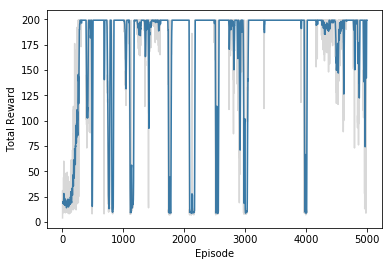

In [32]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [44]:
test_episodes = 20
test_max_steps = 800
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 

            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints\cartpole.ckpt


[2017-08-03 13:11:54,523] Restoring parameters from checkpoints\cartpole.ckpt


In [45]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.